<a href="https://colab.research.google.com/github/hrishipoola/Comparing_Filtering_Methods_MoMA_Artworks/blob/main/Comparing_Filtering_Methods_on_MoMA_Artworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents

1. Introduction
2. Install & Import Packages
3. Read in & Format Data
4. Filter using 4 Methods
<br> Boolean Mask
<br> Loc
<br> Query
<br> np.where
5. Timeit() Compare
6. References

## 1. Introduction

We regularly filter dataframes using boolean masking, loc, query, and numpy.where. I was curious how they actually compared. I came across a similar [comparison of the three operations](https://ramiro.org/notebook/pandas-crosstab-groupby-pivot/) by Ramiro Gomez. Today, we'll demonstrate four filtering methods in achieving the same filtered dataframe and compare their ease of use and runtime. 

Boolean masking, loc, query, and numpy.where can be used interchangeably as a matter of choice and data types, though I find query to be the most elegant because it doesn't require you to repeatedly call the dataframe (it also filters in place). We'll see below that, for the size of data set we're using (>100,000 records),  query is also the fastest, followed by loc, boolean, and np.where. np.where is the slowest as it must first create a list of indexes that meet our conditions.

We'll work with [data](https://github.com/MuseumofModernArt/collection/blob/master/Artworks.csv) from the Museum of Modern Art (MoMA). It includes data on >130,000 artworks acquired by MoMA including title, artist, date made, medium, dimensions, and date acquired. MoMA also has data set of [artists](https://github.com/MuseumofModernArt/collection/blob/master/Artists.csv). If you're interested in other art data sets, check out these from [The Tate](https://github.com/tategallery/collection) and [Carnegie Museum of Art](https://github.com/cmoa/collection). 

As an example task emphasizing performance as a filtering method, let's create a filtered dataframe of sculptures made with bronze by American or German women with first names starting with the letter K that were acquired by MoMA from 1990 onward. Let's then calculate and plot average runtime for each operation using [timeit()](https://docs.python.org/3/library/timeit.html). 

## 2. Install & Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
sns.set_style("darkgrid")
style.use('fivethirtyeight')
import timeit
import io
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


## 3. Read In & Format Data

In [9]:
df_raw = pd.read_csv('https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv')
df_raw.head()

,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,Dimensions,CreditLine,AccessionNumber,Classification,Department,DateAcquired,Cataloged,ObjectID,URL,ThumbnailURL,Circumference (cm),Depth (cm),Diameter (cm),Height (cm),Length (cm),Weight (kg),Width (cm),Seat Height (cm),Duration (sec.)
0,"Ferdinandsbrücke Project, Vienna, Austria (Ele...",Otto Wagner,6210,"(Austrian, 1841–1918)",(Austrian),(1841),(1918),(Male),1896,Ink and cut-and-pasted painted pages on paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",Fractional and promised gift of Jo Carole and ...,885.1996,Architecture,Architecture & Design,1996-04-09,Y,2,http://www.moma.org/collection/works/2,http://www.moma.org/media/W1siZiIsIjU5NDA1Il0s...,NaN,NaN,NaN,48.6000,NaN,NaN,168.9000,NaN,NaN
1,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,7470,"(French, born 1944)",(French),(1944),(0),(Male),1987,Paint and colored pencil on print,"16 x 11 3/4"" (40.6 x 29.8 cm)",Gift of the architect in honor of Lily Auchinc...,1.1995,Architecture,Architecture & Design,1995-01-17,Y,3,http://www.moma.org/collection/works/3,http://www.moma.org/media/W1siZiIsIjk3Il0sWyJw...,NaN,NaN,NaN,40.6401,NaN,NaN,29.8451,NaN,NaN
2,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, pen, color pencil, ink, and gouache ...","13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",Gift of Jo Carole and Ronald S. Lauder,1.1997,Architecture,Architecture & Design,1997-01-15,Y,4,http://www.moma.org/collection/works/4,http://www.moma.org/media/W1siZiIsIjk4Il0sWyJw...,NaN,NaN,NaN,34.3000,NaN,NaN,31.8000,NaN,NaN
3,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1980,Photographic reproduction with colored synthet...,"20 x 20"" (50.8 x 50.8 cm)",Purchase and partial gift of the architect in ...,2.1995,Architecture,Architecture & Design,1995-01-17,Y,5,http://www.moma.org/collection/works/5,http://www.moma.org/media/W1siZiIsIjEyNCJdLFsi...,NaN,NaN,NaN,50.8000,NaN,NaN,50.8000,NaN,NaN
4,"Villa, project, outside Vienna, Austria, Exter...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, color pencil, ink, and gouache on tr...","15 1/8 x 7 1/2"" (38.4 x 19.1 cm)",Gift of Jo Carole and Ronald S. Lauder,2.1997,Architecture,Architecture & Design,1997-01-15,Y,6,http://www.moma.org/collection/works/6,http://www.moma.org/media/W1siZiIsIjEyNiJdLFsi...,NaN,NaN,NaN,38.4000,NaN,NaN,19.1000,NaN,NaN


In [10]:
def format_moma(df_raw):
  # Returns formatted moma dataframe
  global df
  df = df_raw.filter(['Title', 'Artist', 'Nationality', 'Gender', 'Medium', 'Classification', 'DateAcquired'])
  df.Nationality = df.Nationality.str.replace('[^A-Za-z]', '') # Remove anon-alpha characters 
  df.Gender = df.Gender.str.replace('[^A-Za-z]', '').str.strip() # Remove non-alpha characters 
  df.DateAcquired = pd.to_datetime(df.DateAcquired, format='%Y-%m-%d')
  df = df.replace(r'^\s*$', np.nan, regex=True)
  df.dropna(inplace=True) # for the purpose of this exercise, we'll dropna
  df = df.assign(YearAcquired = lambda x: x.DateAcquired.dt.year) # Create YearAcquired column
  return df

format_moma(df_raw)

In [11]:
df.head()

,Title,Artist,Nationality,Gender,Medium,Classification,DateAcquired,YearAcquired
0,"Ferdinandsbrücke Project, Vienna, Austria (Ele...",Otto Wagner,Austrian,Male,Ink and cut-and-pasted painted pages on paper,Architecture,1996-04-09,1996
1,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,French,Male,Paint and colored pencil on print,Architecture,1995-01-17,1995
2,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,Austrian,Male,"Graphite, pen, color pencil, ink, and gouache ...",Architecture,1997-01-15,1997
4,"Villa, project, outside Vienna, Austria, Exter...",Emil Hoppe,Austrian,Male,"Graphite, color pencil, ink, and gouache on tr...",Architecture,1997-01-15,1997
30,"Memorial to the Six Million Jewish Martyrs, pr...",Louis I. Kahn,American,Male,Charcoal and graphite on tracing paper,Architecture,1997-01-15,1997


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114640 entries, 0 to 138150
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Title           114640 non-null  object        
 1   Artist          114640 non-null  object        
 2   Nationality     114640 non-null  object        
 3   Gender          114640 non-null  object        
 4   Medium          114640 non-null  object        
 5   Classification  114640 non-null  object        
 6   DateAcquired    114640 non-null  datetime64[ns]
 7   YearAcquired    114640 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 7.9+ MB


## 4. Filter Using 4 Methods

As an example task emphasizing performance as a filtering method, let's create a filtered dataframe of sculptures made with bronze by American or German women with first names starting with the letter K that were acquired by MoMA from 1990 onward. Each method is used to create the same dataframe. 

### Boolean Mask

In [13]:
filtered = df[(df.Gender=='Female') \
                  & (df.Nationality.isin(['American','German'])) \
                  & (df.Classification=='Sculpture') \
                  & (df.YearAcquired >= 1990) \
                  & (df.Artist.str.startswith('K')) \
                  & (df.Medium.str.contains('bronze'))]
filtered

,Title,Artist,Nationality,Gender,Medium,Classification,DateAcquired,YearAcquired
98186,Group of Figures,Katharina Fritsch,German,Female,"Painted stainless steel, painted bronze, and p...",Sculpture,2009-09-21,2009
115793,Lure,Kiki Smith,American,Female,"Bronze with string, forged bronze hook, and pe...",Sculpture,2013-10-07,2013


### Loc

In [14]:
filtered = df.loc[(df.Gender=='Female') \
                  & (df.Nationality.isin(['American','German'])) \
                  & (df.Classification=='Sculpture') \
                  & (df.YearAcquired >= 1990) \
                  & (df.Artist.str.startswith('K')) \
                  & (df.Medium.str.contains('bronze'))]
filtered

,Title,Artist,Nationality,Gender,Medium,Classification,DateAcquired,YearAcquired
98186,Group of Figures,Katharina Fritsch,German,Female,"Painted stainless steel, painted bronze, and p...",Sculpture,2009-09-21,2009
115793,Lure,Kiki Smith,American,Female,"Bronze with string, forged bronze hook, and pe...",Sculpture,2013-10-07,2013


### Query

In [15]:
artist_mask = df.Artist.str.startswith('K')
medium_mask = df.Medium.str.contains('bronze')
filtered = df.query('Gender == "Female" \
                    & Nationality in ["American", "German"] \
                    & Classification == "Sculpture" \
                    & YearAcquired >= 1990 \
                    & @artist_mask \
                    & @medium_mask') 
filtered

,Title,Artist,Nationality,Gender,Medium,Classification,DateAcquired,YearAcquired
98186,Group of Figures,Katharina Fritsch,German,Female,"Painted stainless steel, painted bronze, and p...",Sculpture,2009-09-21,2009
115793,Lure,Kiki Smith,American,Female,"Bronze with string, forged bronze hook, and pe...",Sculpture,2013-10-07,2013


### np.where

In [16]:
idx = np.where((df.Gender=='Female') \
               & (df.Nationality.isin(['American','German'])) \
               & (df.Classification=='Sculpture') \
               & (df.YearAcquired >= 1990) \
               & (df.Artist.str.startswith('K')) \
               & (df.Medium.str.contains('bronze')))

df.reset_index(drop=True, inplace=True)
df.loc[idx]

,Title,Artist,Nationality,Gender,Medium,Classification,DateAcquired,YearAcquired
84950,Group of Figures,Katharina Fritsch,German,Female,"Painted stainless steel, painted bronze, and p...",Sculpture,2009-09-21,2009
97808,Lure,Kiki Smith,American,Female,"Bronze with string, forged bronze hook, and pe...",Sculpture,2013-10-07,2013


## 5. Timeit() Compare

In [17]:
def boolean(df):
  df[(df.Gender=='Female') \
                  & (df.Nationality.isin(['American','German'])) \
                  & (df.Classification=='Sculpture') \
                  & (df.YearAcquired >= 1990) \
                  & (df.Artist.str.startswith('K')) \
                  & (df.Medium.str.contains('bronze'))]

def loc(df):
  df.loc[(df.Gender=='Female') \
                  & (df.Nationality.isin(['American','German'])) \
                  & (df.Classification=='Sculpture') \
                  & (df.YearAcquired >= 1990) \
                  & (df.Artist.str.startswith('K')) \
                  & (df.Medium.str.contains('bronze'))]

def query(df):
  artist_mask = df.Artist.str.startswith('K')
  medium_mask = df.Medium.str.contains('bronze')
  df.query('Gender == "Female" \
                  & Nationality in ["American", "German"] \
                  & Classification == "Sculpture" \
                  & YearAcquired >= 1990 \
                  & @artist_mask \
                  & @medium_mask') 
  
def where(df):
  idx = np.where((df.Gender=='Female') \
               & (df.Nationality.isin(['American','German'])) \
               & (df.Classification=='Sculpture') \
               & (df.YearAcquired >= 1990) \
               & (df.Artist.str.startswith('K')) \
               & (df.Medium.str.contains('bronze')))
  df.reset_index(drop=True, inplace=True)
  df.loc[idx]


funcs = [boolean, loc, query, where]
runtimes = []
repetitions = 10

for func in funcs:
  duration = (timeit.timeit('func(df)', number=repetitions, globals=globals()) / repetitions)*1e6 # average duration in milliseconds
  runtimes.append({'Function': func.__name__, 'duration': duration})

runtimes = pd.DataFrame(runtimes).sort_values(by='duration')

[Text(0, 0.5, ''), Text(0.5, 0, 'Duration (ms)'), Text(0.5, 1.0, 'Runtime')]

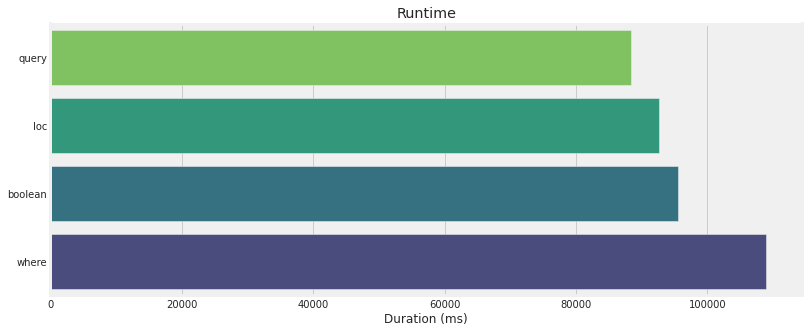

In [27]:
# Plot
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='duration', 
            y='Function', 
            data=runtimes, 
            ax=ax,
            palette='viridis_r')

ax.set(title='Runtime', xlabel='Duration (ms)',ylabel=None)

In [28]:
runtimes

,Function,duration
2,query,88352.6926
1,loc,92710.4935
0,boolean,95475.2152
3,where,108986.8585


## 6. References

https://github.com/MuseumofModernArt/collection

https://ramiro.org/notebook/pandas-crosstab-groupby-pivot/

https://stackoverflow.com/questions/38886080/python-pandas-series-why-use-loc

https://www.listendata.com/2019/07/how-to-filter-pandas-dataframe.html

https://www.geeksforgeeks.org/ways-to-filter-pandas-dataframe-by-column-values/

https://www.geeksforgeeks.org/python-filtering-data-with-pandas-query-method/

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html